In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [46]:
train = pd.read_csv("./train.csv") #Datensatz angeben


In [47]:
# dropping irrelevant columns
train.drop('Cabin', axis=1, inplace=True)
train.drop('PassengerId', axis=1, inplace=True)
train.drop('Name', axis=1, inplace=True)
train.drop('Ticket', axis=1, inplace=True)
#train = train.dropna(subset=['Embarked'])
train.fillna(train['Embarked'].mode()[0])

# Replace Sex Values male=1, female=2
train['Sex'] = train['Sex'].str.lower().map({'male': 1, 'female': 2}).fillna(train['Sex'])# Count rows with NaN values in any column
train['Embarked'] = train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

train['Age'] = train['Age'].fillna(train['Age'].median())
#train = train.dropna(subset=['Age']) # Had no effect on the result 0,07 -> 0,08
train


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2.0
1,1,1,2,38.0,1,0,71.2833,0.0
2,1,3,2,26.0,0,0,7.9250,2.0
3,1,1,2,35.0,1,0,53.1000,2.0
4,0,3,1,35.0,0,0,8.0500,2.0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2.0
887,1,1,2,19.0,0,0,30.0000,2.0
888,0,3,2,28.0,1,2,23.4500,2.0
889,1,1,1,26.0,0,0,30.0000,0.0


In [48]:
# Modify Dataset and Exploration

nan_count = train.isna().any(axis=1).sum()
# To identify which columns have NaN values and count them
nan_columns = train.isna().sum()
print(nan_columns)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64


In [49]:
x = train[["Sex", "Pclass", "Fare", "Age", "SibSp"]]
y = train["Survived"]
# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Checking the sizes of the datasets
print("x_train size:", x_train.shape)
print("x_test size:", x_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)


x_train size: (712, 5)
x_test size: (179, 5)
y_train size: (712,)
y_test size: (179,)


In [50]:
def evaluate_model(y_test, y_pred):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [51]:
# Applying Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [52]:
'''
best = 1
best_acc = 0
for i in range(1, 800):
    rf_model = RandomForestClassifier(n_estimators=i, random_state=42)
    rf_model.fit(x_train, y_train)
    rf_y_pred = rf_model.predict(x_test)
    if accuracy_score(y_test, rf_y_pred) > best_acc:
        best = i
        best_acc = accuracy_score(y_test, rf_y_pred)
        
rf_model = RandomForestClassifier(n_estimators=best, random_state=42)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)
print(best)
print("Random Forest Evaluation:")
evaluate_model(y_test, rf_y_pred)
'''
rf_model = RandomForestClassifier(n_estimators=111, random_state=42)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)


In [53]:
y_pred = model.predict(x_test)

# Evaluation
print("Logistic Regression:")
evaluate_model(y_test, y_pred)

print("Random Forest Evaluation:")
evaluate_model(y_test, rf_y_pred)
# Cross-validation
cv_scores = cross_val_score(model, x, y, cv=10)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Logistic Regression:
Accuracy: 0.7932960893854749
Confusion Matrix:
 [[89 16]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

Random Forest Evaluation:
Accuracy: 0.8100558659217877
Confusion Matrix:
 [[90 15]
 [19 55]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Cross-validation scores: [0.81111111 0.78651685 0.74157303 0.80898876 0.80898876 0.76404494
 0.78651685 0.7752809  0.

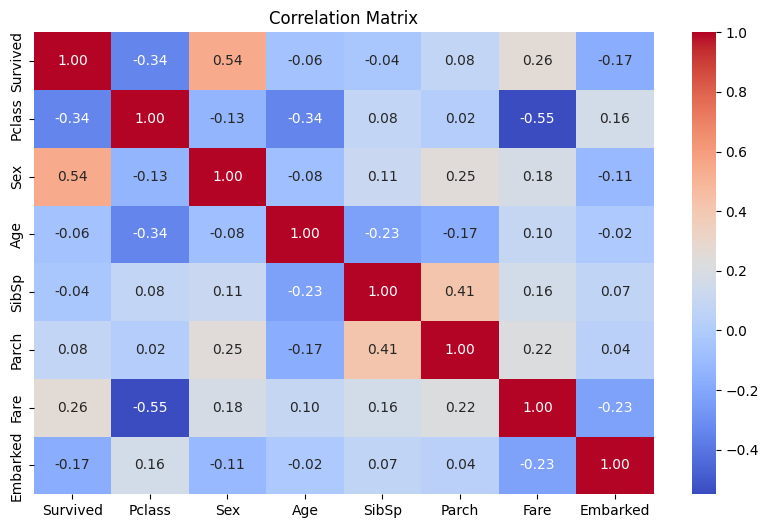

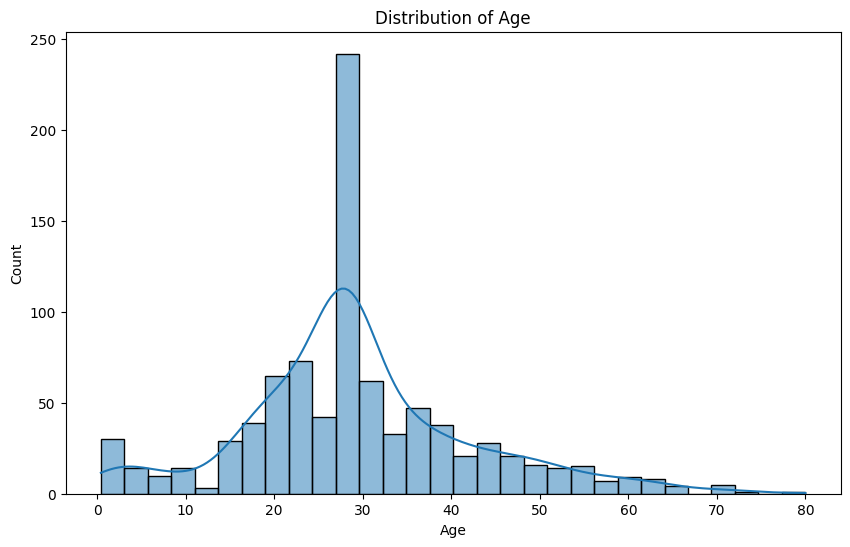

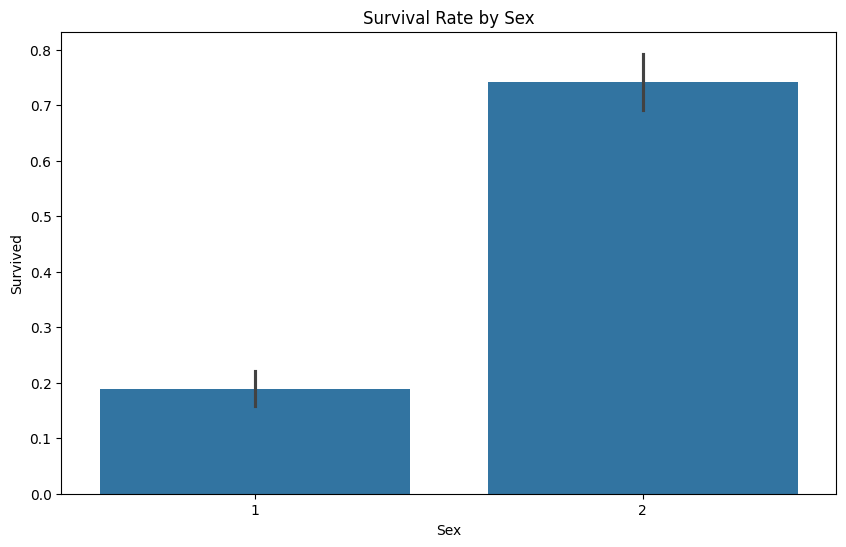

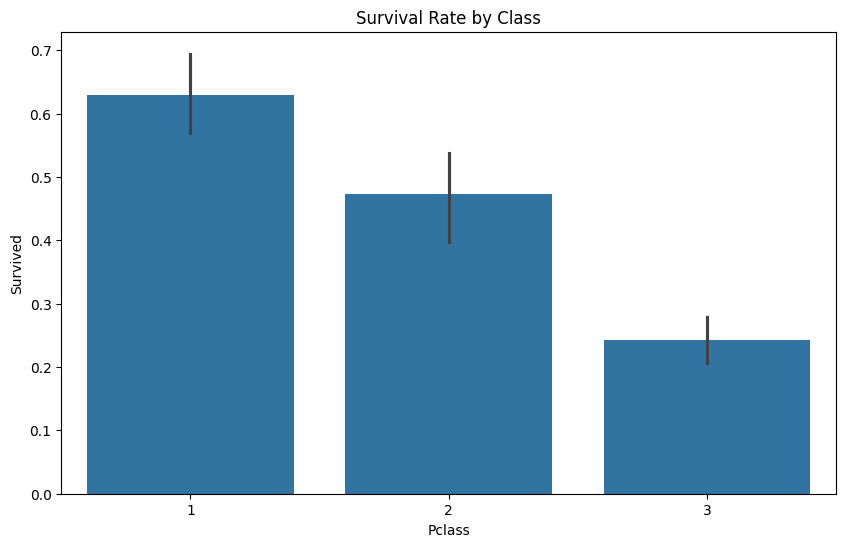

In [54]:
# Visual Explorative Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Plotting the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(train['Age'], kde=True)
plt.title('Distribution of Age')
plt.show()

# Visualizing the survival rate by sex
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title('Survival Rate by Sex')
plt.show()

# Visualizing the survival rate by class
plt.figure(figsize=(10, 6))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title('Survival Rate by Class')
plt.show()